## TPE Tuning

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,HipsSumVariancebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,0,84.5123,1,25.0,0.150000,169.300000,0.610000,223.340000,36.000000,724.04000,...,227.925000,0.495000,223.250000,27.445000,665.065000,2.725000,-516.185000,2.638340,2397.0,3164.85
1,1,75.3699,1,26.0,0.097733,175.103337,0.562332,197.321714,42.533788,614.18352,...,222.355754,0.500577,218.584302,30.381415,651.981453,3.154282,2595.481588,3.146500,1662.5,2648.30
2,0,80.9068,0,29.0,0.100000,161.280000,0.540000,174.530000,35.940000,536.85000,...,221.760000,0.445000,NaN,30.565000,NaN,3.120000,4287.780000,2.897730,2188.0,3602.50
3,0,77.8932,0,28.0,0.110000,235.890000,0.510000,231.560000,41.660000,690.33000,...,217.450000,0.540000,236.750000,30.465000,729.545000,3.010000,-741.895000,2.734850,2292.5,3267.45
4,1,75.3534,1,24.0,0.140000,192.290000,0.550000,218.500000,35.280000,681.70000,...,269.565000,0.390000,219.405000,26.560000,608.050000,2.565000,456.550000,2.444245,1082.0,2550.50


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

X_train.shape, X_test.shape

((366, 22), (158, 22))

In [6]:
imputer_nonLin = IterativeImputer(
    estimator=ExtraTreesRegressor(),
    random_state=42,
)

imputer_nonLin.fit(X_train)
X_train_missForest = imputer_nonLin.transform(X_train)
X_test_missForest = imputer_nonLin.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [7]:
X_train_missForest_t = pd.DataFrame(
    X_train_missForest, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_missForest_t = pd.DataFrame(
    X_test_missForest, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [8]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_missForest_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [9]:
X_train_t = pipe.transform(X_train_missForest_t)
X_test_t = pipe.transform(X_test_missForest_t)

X_train_t.shape, X_test_t.shape

((366, 22), (158, 22))

In [10]:
# Store selected feature names before transformation
sel = ['Ageatscreening', 'MMSE0m', 'HipsContrastbaseline',
       'HipsEntropybaseline', 'ERCsContrastbaseline', 'ERCsCorelationbaseline',
       'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'HipposcampusVolumebaseline']

In [11]:
# Store selected feature names before transformation
selected_features = [col for col in sel if col in X_train_t.columns]
selected_features

['Ageatscreening',
 'MMSE0m',
 'HipsContrastbaseline',
 'HipsEntropybaseline',
 'ERCsContrastbaseline',
 'ERCsCorelationbaseline',
 'ERCs_thicknessbaseline',
 'ERCsVolumebaseline',
 'HipposcampusVolumebaseline']

In [12]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((366, 9), (158, 9))

## TPE

In [ ]:
def objective(trial):
        
    skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
    
    # Base learner
    learner = DecisionTreeRegressor(
            max_depth=trial.suggest_int("base_max_depth", 3, 6),
            criterion=trial.suggest_categorical("reg_criterion", ['squared_error', 'friedman_mse']),
            min_samples_leaf = trial.suggest_float("rf_min_samples_leaf", 0.005, 0.05),
            random_state=42
    )
    
    ngb_n_estimators = trial.suggest_int("ngb_n_estimators", 100, 500)
    ngb_learning_rate = trial.suggest_float("ngb_learning_rate", 0.005, 0.2, log=True)    
    model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                          Base=learner,
                          n_estimators=ngb_n_estimators,
                          learning_rate=ngb_learning_rate,
                          natural_gradient=True,
                          verbose=False) 

    score = cross_val_score(model, X_train_t, y_train, scoring="balanced_accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [ ]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=20)

[I 2025-08-03 22:58:30,404] A new study created in memory with name: no-name-4c73f10e-9c94-4b49-b9df-7ce855623d93


In [15]:
study.best_params

{'base_max_depth': 3,
 'reg_criterion': 'friedman_mse',
 'rf_min_samples_leaf': 0.030110298790621746,
 'ngb_n_estimators': 216,
 'ngb_learning_rate': 0.02112984322223793}

In [16]:
study.best_value

0.7560897435897436

In [17]:
r = study.trials_dataframe()

r.head()

,number,value,datetime_start,datetime_complete,duration,params_base_max_depth,params_ngb_learning_rate,params_ngb_n_estimators,params_reg_criterion,params_rf_min_samples_leaf,state
0,0,0.709027,2025-08-03 21:48:18.708140,2025-08-03 21:48:59.070378,0 days 00:00:40.362238,5,0.121589,303,friedman_mse,0.005095,COMPLETE
1,1,0.720683,2025-08-03 21:48:59.070378,2025-08-03 21:49:43.639536,0 days 00:00:44.569158,5,0.009755,461,friedman_mse,0.041180,COMPLETE
2,2,0.741642,2025-08-03 21:49:43.639536,2025-08-03 21:50:29.444637,0 days 00:00:45.805101,5,0.153786,422,squared_error,0.038048,COMPLETE
3,3,0.723260,2025-08-03 21:50:29.445599,2025-08-03 21:50:39.910253,0 days 00:00:10.464654,4,0.073367,110,friedman_mse,0.031962,COMPLETE
4,4,0.714093,2025-08-03 21:50:39.926323,2025-08-03 21:50:49.844082,0 days 00:00:09.917759,6,0.023642,106,squared_error,0.018961,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_2172\2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


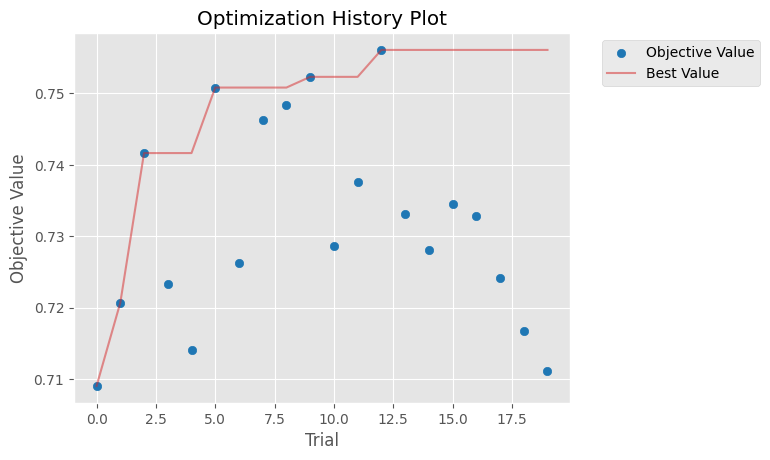

In [18]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_2172\3449611284.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<Axes: xlabel='ngb_learning_rate', ylabel='Objective Value'>,
       <Axes: xlabel='ngb_n_estimators'>], dtype=object)

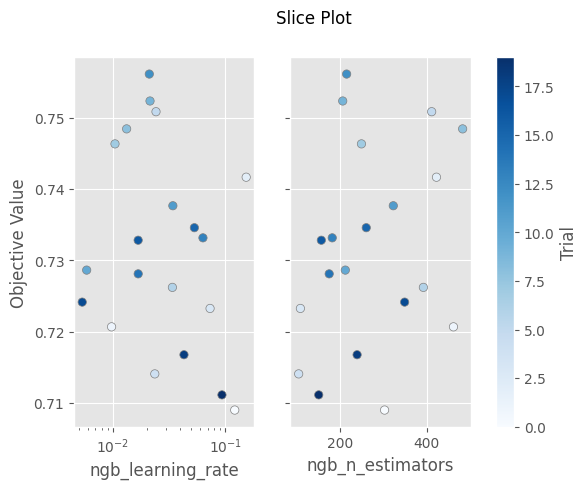

In [19]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["ngb_n_estimators", "ngb_learning_rate"],
)

C:\Users\steve\AppData\Local\Temp\ipykernel_2172\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

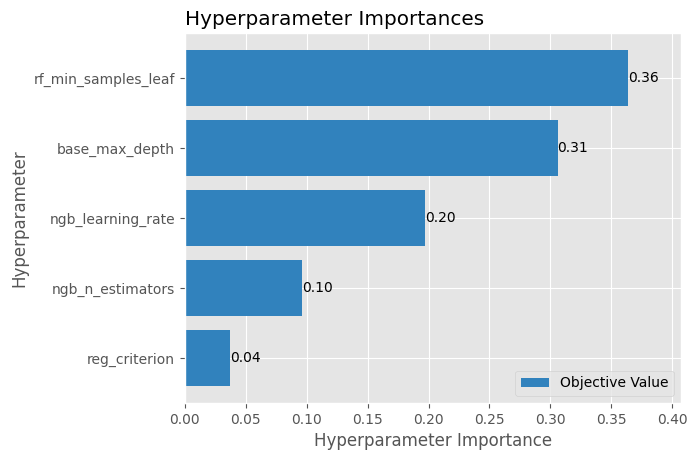

In [20]:
optuna.visualization.matplotlib.plot_param_importances(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_2172\1937692550.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

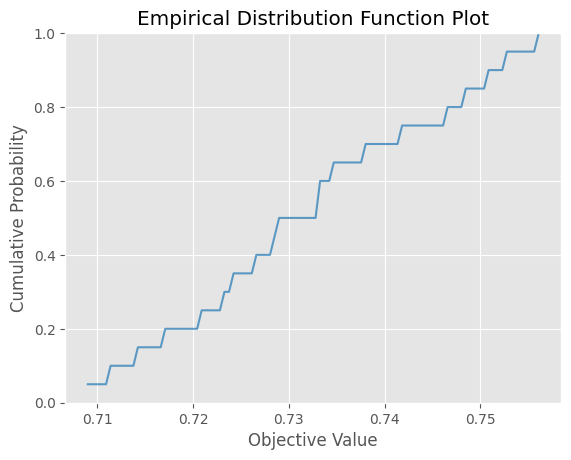

In [21]:
optuna.visualization.matplotlib.plot_edf([study])


### Classification

In [22]:
def run_model(classifier_name, sel_method, X_train, y_train):
        
        # Recreate the best base learner from the study
        base_learner = DecisionTreeRegressor(
                max_depth=study.best_params["base_max_depth"],
                criterion=study.best_params["reg_criterion"],
                min_samples_leaf=study.best_params["rf_min_samples_leaf"],
                random_state=42
        )
        
        model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                              Base=base_learner,
                              n_estimators=study.best_params['ngb_n_estimators'],
                              learning_rate=study.best_params['ngb_learning_rate'], 
                              random_state=42
        )

        if sel_method == "Boruta":
                sel_method = "Boruta" 
        else: 
                sel_method = "Complete"
        
        skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=skf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": sel_method,
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": len(X_train.columns),
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [23]:
trained_ngb_n, metrics_ngb_n = run_model("NGBoost", "Complete", X_train_missForest_t, y_train)
trained_ngb_t, metrics_ngb_t = run_model("NGBoost", "Boruta", X_train_t, y_train)

[iter 0] loss=1.0747 val_loss=0.0000 scale=4.0000 norm=13.6569
[iter 100] loss=0.3470 val_loss=0.0000 scale=1.0000 norm=1.7898
[iter 200] loss=0.3202 val_loss=0.0000 scale=0.2500 norm=0.4408
[iter 0] loss=1.0760 val_loss=0.0000 scale=4.0000 norm=13.6569
[iter 100] loss=0.3216 val_loss=0.0000 scale=1.0000 norm=1.7122
[iter 200] loss=0.2953 val_loss=0.0000 scale=0.5000 norm=0.8402
[iter 0] loss=1.0760 val_loss=0.0000 scale=2.0000 norm=6.8284
[iter 100] loss=0.3237 val_loss=0.0000 scale=1.0000 norm=1.7457
[iter 200] loss=0.2838 val_loss=0.0000 scale=0.2500 norm=0.4216
[iter 0] loss=1.0760 val_loss=0.0000 scale=4.0000 norm=13.6569
[iter 100] loss=0.3331 val_loss=0.0000 scale=1.0000 norm=1.7526
[iter 200] loss=0.3145 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=1.0760 val_loss=0.0000 scale=2.0000 norm=6.8284
[iter 100] loss=0.3367 val_loss=0.0000 scale=1.0000 norm=1.7491
[iter 200] loss=0.3149 val_loss=0.0000 scale=0.2500 norm=0.4319
[iter 0] loss=1.0744 val_loss=0.0000 scale=2.00

In [24]:
validation_df = pd.concat([metrics_ngb_n, metrics_ngb_t])
validation_df_report = validation_df.set_index(["Classifier", "Metric", "Feature Selection", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Classifier Metric            Feature Selection Fit Time Total Features               
NGBoost    balanced_accuracy Complete          2.473    22                   0.875   
                             Boruta            1.868    9                    0.849   

                                                                        Std Train  \
Classifier Metric            Feature Selection Fit Time Total Features              
NGBoost    balanced_accuracy Complete          2.473    22                  0.012   
                             Boruta            1.868    9                   0.010   

                                                                        Mean Test  \
Classifier Metric            Feature Selection Fit Time Total Features              
NGBoost    balanced_accuracy Complete          2.473    22                  0.749   
                             Boruta            1.868    9                   0.756   

                                                                        Std Test  
Classifier Metric            Feature Selection Fit Time Total Features            
NGBoost    balanced_accuracy Complete          2.473    22                 0.051  
                             Boruta            1.868    9                  0.035

In [25]:
from sklearn.utils import resample

def bootstrap_ci(model, X, y, metric_fn, n_iterations, ci=0.95, use_proba=False):
    scores = []
    n = len(X)
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X, y, n_samples=n, stratify=y)
        try:
            y_pred = model.predict_proba(X_resampled) if use_proba else model.predict(X_resampled)
            score = metric_fn(y_resampled, y_pred)
            if not np.isnan(score):
                scores.append(score)
        except Exception:
            # Skip this bootstrap sample if error occurs (e.g. missing class for roc_auc)
            continue
    if len(scores) == 0:
        return (np.nan, np.nan)
    lower = np.percentile(scores, (1 - ci) / 2 * 100)
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    std_dev = np.std(scores)
    return round(lower, 3), round(upper, 3), round(std_dev, 3)

In [26]:
from sklearn.metrics import confusion_matrix

def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = total - (tp + fp + fn)
    specificity = tn / (tn + fp)
    return round(np.nanmean(specificity), 3)

In [27]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        if isinstance(X_train, np.ndarray):
                columns = X_train.shape[1]
        else:
                columns = len(X_train.columns)        
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        # Calculate metrics
        metrics_train = {
                "accuracy": accuracy_score(y_train, pred_train),
                "balanced_accuracy": balanced_accuracy_score(y_train, pred_train),
                "precision_macro": precision_score(y_train, pred_train, average="macro", zero_division=0),
                "recall_macro": recall_score(y_train, pred_train, average="macro", zero_division=0),
                "f1_macro": f1_score(y_train, pred_train, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_train, pred_train_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_train, pred_train),
        }

        metrics_test = {
                "accuracy": accuracy_score(y_test, pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, pred_test),
                "precision_macro": precision_score(y_test, pred_test, average="macro", zero_division=0),
                "recall_macro": recall_score(y_test, pred_test, average="macro", zero_division=0),
                "f1_macro": f1_score(y_test, pred_test, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_test, pred_test_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_test, pred_test),
        }
                
        elapsed_time = time.time() - start_time
        
        # Metric functions for bootstrap CI (exclude ROC AUC here)
        metric_fns = {
                "accuracy": accuracy_score,
                "balanced_accuracy": balanced_accuracy_score,
                "precision_macro": lambda yt, yp: precision_score(yt, yp, average="macro", zero_division=0),
                "recall_macro": lambda yt, yp: recall_score(yt, yp, average="macro", zero_division=0),
                "f1_macro": lambda yt, yp: f1_score(yt, yp, average="macro", zero_division=0),
                "roc_auc_macro": lambda yt, yp: roc_auc_score(yt, yp, average="macro", multi_class="ovr"),
                "specificity_macro": lambda yt, yp: compute_specificity(yt, yp),
        }

        # Bootstrap confidence intervals
        ci_test = {
                m: bootstrap_ci(
                model, X_test, y_test, fn,
                n_iterations=1000,
                use_proba=(m == "roc_auc_macro")
                )
                for m, fn in metric_fns.items()
        }

        # Separate CI bounds and std with clear variable names
        ci_bounds = []
        std_values = []
                
        for lower, upper, std in ci_test.values():
                ci_bounds.append(f"[{round(lower, 3)}, {round(upper, 3)}]")
                std_values.append(round(std, 3)) 
                
        # Round metric values
        train_rounded = [round(score, 3) for score in metrics_train.values()]
        test_rounded = [round(score, 3) for score in metrics_test.values()] 
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": list(metrics_train.keys()),      
                "Train data": train_rounded,
                "Test data": test_rounded,
                "95% CI": ci_bounds,
                "Std Dev": std_values,
        })
        
        return pred_metrics_df

In [28]:
results = "all"
prediction_df_report = None

if results == "all":

    pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_ngb_n, pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":

    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier Classification Time Total Features Metric                          
Boruta            NGBoost    0.646               22             accuracy                0.872   
                                                                balanced_accuracy       0.879   
                                                                precision_macro         0.871   
                                                                recall_macro            0.879   
                                                                f1_macro                0.874   
                                                                roc_auc_macro           0.972   
                                                                specificity_macro       0.934   
                             0.500               9              accuracy                0.833   
                                                                balanced_accuracy       0.844   
                                                                precision_macro         0.836   
                                                                recall_macro            0.844   
                                                                f1_macro                0.839   
                                                                roc_auc_macro           0.959   
                                                                specificity_macro       0.914   

                                                                                   Test data  \
Feature Selection Classifier Classification Time Total Features Metric                         
Boruta            NGBoost    0.646               22             accuracy               0.734   
                                                                balanced_accuracy      0.733   
                                                                precision_macro        0.734   
                                                                recall_macro           0.733   
                                                                f1_macro               0.734   
                                                                roc_auc_macro          0.885   
                                                                specificity_macro      0.866   
                             0.500               9              accuracy               0.753   
                                                                balanced_accuracy      0.757   
                                                                precision_macro        0.748   
                                                                recall_macro           0.757   
                                                                f1_macro               0.750   
                                                                roc_auc_macro          0.880   
                                                                specificity_macro      0.877   

                                                                                           95% CI  \
Feature Selection Classifier Classification Time Total Features Metric                              
Boruta            NGBoost    0.646               22             accuracy           [0.665, 0.797]   
                                                                balanced_accuracy  [0.664, 0.796]   
                                                                precision_macro    [0.666, 0.807]   
                                                                recall_macro       [0.662, 0.796]   
                                                                f1_macro           [0.666, 0.799]   
                                                                roc_auc_macro      [0.845, 0.926]   
                                                                specificity_macro  [0.833, 0.901]   
                             0.500               9              accuracy           [

### Export model

In [29]:
trained_ngb_t

NGBClassifier(Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                                         min_samples_leaf=0.030110298790621746,
                                         random_state=42),
              learning_rate=0.02112984322223793, n_estimators=216,
              random_state=RandomState(MT19937) at 0x1C168109F40)

In [30]:
import pickle

# Save the trained model using pickle
with open("ngboost_model.pkl", "wb") as file:
    pickle.dump(trained_ngb_t, file)

print("NGBoost model saved successfully!")

NGBoost model saved successfully!


In [31]:
# Load the saved model using pickle
with open("ngboost_model.pkl", "rb") as file:
    loaded_model_ngb = pickle.load(file)